## Capstone Project Notebook 03/02/2026 Function 2 ##
### Updated with improved Bayesian Optimization strategy
### Goal: MAXIMIZE the objective function

In [56]:
# Section 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

In [57]:
wk = 2 # Set week number

## Load Updated Dataset 
Now includes 11 samples (10 initial + 1 from last week)

In [58]:
# Load the updated dataset with all 11 points
INPUT_FILE = 'f2_w2_inputs.npy'   # Updated file with 11 points, shape (11,2)
OUTPUT_FILE = 'f2_w2_outputs.npy' # Updated file with 11 outputs, shape (11,)

In [59]:
X = np.load(INPUT_FILE)  # X is the input matrix, shape is (11,2)
Y = np.load(OUTPUT_FILE) # Y is the output vector, shape (11,)

In [60]:
# Display all data points
print("Input function 2 data (all 11 points): \n", X)
print("\nOutput function 2 data (all 11 points): \n", Y)

Input function 2 data (all 11 points): 
 [[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [0.705607   1.48793   ]]

Output function 2 data (all 11 points): 
 [ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522  0.52461916]


In [61]:
print(f"Loaded {X.shape[0]} points in {X.shape[1]}D")
print(f"Current best (MAXIMUM): {Y.max():.6f} at {X[Y.argmax()]}")
print(f"Note: We're MAXIMIZING, so higher is better!")
X = np.atleast_2d(X)  # Make sure X is always 2D
Y = Y.ravel()  # Forces Y to be 1D flat

Loaded 11 points in 2D
Current best (MAXIMUM): 0.611205 at [0.70263656 0.9265642 ]
Note: We're MAXIMIZING, so higher is better!


## Data Analysis
Understand our search space coverage and current performance

In [62]:
print("="*70)
print("F2 DATASET ANALYSIS")
print("="*70)
print(f"\nInput ranges:")
print(f"  X1: [{X[:, 0].min():.4f}, {X[:, 0].max():.4f}]")
print(f"  X2: [{X[:, 1].min():.4f}, {X[:, 1].max():.4f}]")

print(f"\nOutput statistics:")
print(f"  Min:    {Y.min():.6f}")
print(f"  Max:    {Y.max():.6f}")
print(f"  Mean:   {Y.mean():.6f}")
print(f"  Median: {np.median(Y):.6f}")
print(f"  Std:    {Y.std():.6f}")

# Find best point (MAXIMUM)
best_idx = np.argmax(Y)
print(f"\n🎯 BEST POINT SO FAR:")
print(f"  Input:  [{X[best_idx, 0]:.6f}, {X[best_idx, 1]:.6f}]")
print(f"  Output: {Y[best_idx]:.6f}")

# Show all points sorted by performance (highest first)
sorted_indices = np.argsort(Y)[::-1]  # Descending order
print(f"\n📊 ALL DATA POINTS (sorted by value, highest first):")
for i in range(len(Y)):
    idx = sorted_indices[i]
    marker = "⭐" if idx == best_idx else "  "
    print(f"{marker} {i+1:2d}. X=[{X[idx, 0]:.4f}, {X[idx, 1]:.4f}] → Y={Y[idx]:.6f}")

F2 DATASET ANALYSIS

Input ranges:
  X1: [0.1427, 0.8778]
  X2: [0.0287, 1.4879]

Output statistics:
  Min:    -0.065624
  Max:    0.611205
  Mean:   0.257396
  Median: 0.244619
  Std:    0.230896

🎯 BEST POINT SO FAR:
  Input:  [0.702637, 0.926564]
  Output: 0.611205

📊 ALL DATA POINTS (sorted by value, highest first):
⭐  1. X=[0.7026, 0.9266] → Y=0.611205
    2. X=[0.6658, 0.1240] → Y=0.538996
    3. X=[0.7056, 1.4879] → Y=0.524619
    4. X=[0.8778, 0.7786] → Y=0.420586
    5. X=[0.8453, 0.7111] → Y=0.293993
    6. X=[0.4382, 0.6850] → Y=0.244619
    7. X=[0.4546, 0.2905] → Y=0.214965
    8. X=[0.3417, 0.0287] → Y=0.038749
    9. X=[0.5777, 0.7720] → Y=0.023106
   10. X=[0.3386, 0.2139] → Y=-0.013858
   11. X=[0.1427, 0.3490] → Y=-0.065624


## Section 2: Fit Gaussian Process Surrogate Model

In [63]:
# Kernel optimized for F2 data scale
kernel = ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3)) * \
         Matern(length_scale=0.5, length_scale_bounds=(0.01, 10.0), nu=2.5) + \
         WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-9, 1e-1))

In [64]:
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=25,
    normalize_y=True,  # Better numerical stability
    random_state=42
)

In [65]:

gp.fit(X, Y)
print(f"GP fitted. Learned kernel: {gp.kernel_}")

GP fitted. Learned kernel: 1.05**2 * Matern(length_scale=0.146, nu=2.5) + WhiteKernel(noise_level=2.35e-09)


## Section 3: Define Acquisition Functions
**Configured for MAXIMIZATION**

In [66]:
def expected_improvement(X_new, gp, y_best, xi=0.01):
    """
    Expected Improvement acquisition function for MAXIMIZATION.
    
    Args:
        X_new: Points to evaluate
        gp: Fitted Gaussian Process
        y_best: Current best (maximum) value
        xi: Exploration parameter
    
    Returns:
        EI values (higher is better)
    """
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    
    # For maximization: improvement when mu > y_best
    imp = mu - y_best - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-9] = 0.0
    
    return ei

def upper_confidence_bound(X_new, gp, kappa=2.0):
    """
    Upper Confidence Bound acquisition function for MAXIMIZATION.
    
    Args:
        X_new: Points to evaluate  
        gp: Fitted Gaussian Process
        kappa: Exploration parameter
    
    Returns:
        UCB values (higher is better for maximization)
    """
    mu, sigma = gp.predict(X_new, return_std=True)
    # For maximization: we want mu + kappa*sigma (higher is better)
    return mu + kappa * sigma

## Section 4: Optimize Acquisition Functions

In [67]:
# Define search bounds
bounds = [(0.0, 1.0), (0.0, 1.6)]  # X1, X2 bounds

# Current best value (MAXIMUM)
y_best = Y.max()

print("="*70)
print("OPTIMIZING EXPECTED IMPROVEMENT (EI)")
print("="*70)

def neg_ei(x):
    """Negative EI for use with scipy minimize"""
    return -expected_improvement(x.reshape(1, -1), gp, y_best, xi=0.01)[0]

best_ei = np.inf
x_next_ei = None

# Multiple random restarts
for i in range(30):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ei, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ei:
        best_ei = result.fun
        x_next_ei = result.x

# Predict at EI suggestion
mu_ei, sigma_ei = gp.predict(x_next_ei.reshape(1, -1), return_std=True)

print(f"EI suggests: [{x_next_ei[0]:.6f}, {x_next_ei[1]:.6f}]")
print(f"Predicted value: {mu_ei[0]:.6f} ± {sigma_ei[0]:.6f}")
print(f"Expected Improvement: {-best_ei:.6f}")

OPTIMIZING EXPECTED IMPROVEMENT (EI)
EI suggests: [0.773571, 0.963916]
Predicted value: 0.606117 ± 0.139369
Expected Improvement: 0.048381


In [68]:
print("\n" + "="*70)
print("OPTIMIZING UPPER CONFIDENCE BOUND (UCB)")
print("="*70)

kappa = 2.0

def neg_ucb(x):
    """Negative UCB for use with scipy minimize"""
    return -upper_confidence_bound(x.reshape(1, -1), gp, kappa)[0]

best_ucb = np.inf
x_next_ucb = None

# Multiple random restarts
for i in range(30):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ucb, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ucb:
        best_ucb = result.fun
        x_next_ucb = result.x

# Predict at UCB suggestion
mu_ucb, sigma_ucb = gp.predict(x_next_ucb.reshape(1, -1), return_std=True)

print(f"UCB suggests: [{x_next_ucb[0]:.6f}, {x_next_ucb[1]:.6f}]")
print(f"Predicted value: {mu_ucb[0]:.6f} ± {sigma_ucb[0]:.6f}")
print(f"UCB value: {-best_ucb:.6f}")


OPTIMIZING UPPER CONFIDENCE BOUND (UCB)
UCB suggests: [0.809090, 0.997087]
Predicted value: 0.538515 ± 0.188908
UCB value: 0.916331


## Section 5: Local Refinement Strategy

In [69]:
print("\n" + "="*70)
print("LOCAL REFINEMENT - Points near current best")
print("="*70)

best_idx = np.argmax(Y)  # MAXIMUM
best_point = X[best_idx]

step_size = 0.05
local_points = [
    [best_point[0] - step_size, best_point[1]],
    [best_point[0] + step_size, best_point[1]],
    [best_point[0], best_point[1] - step_size],
    [best_point[0], best_point[1] + step_size],
    [best_point[0] - step_size, best_point[1] - step_size],
    [best_point[0] + step_size, best_point[1] + step_size],
]

print(f"Current best: [{best_point[0]:.6f}, {best_point[1]:.6f}] → {Y[best_idx]:.6f}\n")

best_local_pred = -np.inf
best_local_point = None

for i, lp in enumerate(local_points, 1):
    # Check bounds
    if all(bounds[j][0] <= lp[j] <= bounds[j][1] for j in range(2)):
        mu, std = gp.predict(np.array(lp).reshape(1, -1), return_std=True)
        print(f"  Option {i}: [{lp[0]:.6f}, {lp[1]:.6f}] → Predicted: {mu[0]:.6f} ± {std[0]:.6f}")
        
        if mu[0] > best_local_pred:  # MAXIMIZE
            best_local_pred = mu[0]
            best_local_point = lp

if best_local_point:
    print(f"\nBest local refinement: [{best_local_point[0]:.6f}, {best_local_point[1]:.6f}]")


LOCAL REFINEMENT - Points near current best
Current best: [0.702637, 0.926564] → 0.611205

  Option 1: [0.652637, 0.926564] → Predicted: 0.521889 ± 0.092897
  Option 2: [0.752637, 0.926564] → Predicted: 0.624814 ± 0.092205
  Option 3: [0.702637, 0.876564] → Predicted: 0.518779 ± 0.087709
  Option 4: [0.702637, 0.976564] → Predicted: 0.612433 ± 0.096388
  Option 5: [0.652637, 0.876564] → Predicted: 0.414444 ± 0.103780
  Option 6: [0.752637, 0.976564] → Predicted: 0.612881 ± 0.128196

Best local refinement: [0.752637, 0.926564]


## Section 6: Visualization

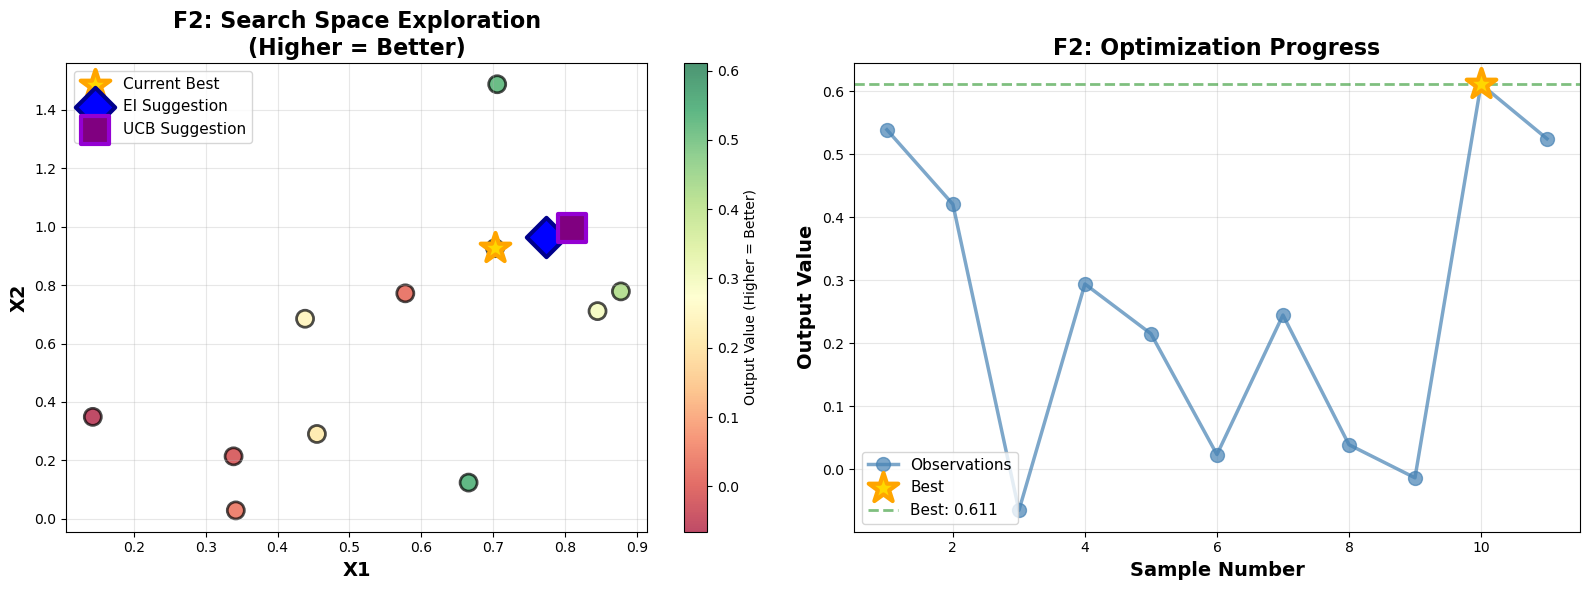

In [70]:
# Create a 2D visualization of the search space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot of all points
ax1 = axes[0]
scatter = ax1.scatter(X[:, 0], X[:, 1], c=Y, cmap='RdYlGn', 
                      s=150, alpha=0.7, edgecolors='black', linewidth=2)
ax1.scatter(X[best_idx, 0], X[best_idx, 1], 
           c='gold', s=500, marker='*', 
           edgecolors='orange', linewidth=3, label='Current Best', zorder=10)
ax1.scatter(x_next_ei[0], x_next_ei[1], 
           c='blue', s=400, marker='D', 
           edgecolors='darkblue', linewidth=3, label='EI Suggestion', zorder=10)
ax1.scatter(x_next_ucb[0], x_next_ucb[1], 
           c='purple', s=400, marker='s', 
           edgecolors='darkviolet', linewidth=3, label='UCB Suggestion', zorder=10)

ax1.set_xlabel('X1', fontsize=14, fontweight='bold')
ax1.set_ylabel('X2', fontsize=14, fontweight='bold')
ax1.set_title('F2: Search Space Exploration\n(Higher = Better)', fontsize=16, fontweight='bold')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Output Value (Higher = Better)')

# Plot 2: Progress over iterations
ax2 = axes[1]
ax2.plot(range(1, len(Y)+1), Y, 'o-', linewidth=2.5, markersize=10, 
        color='steelblue', alpha=0.7, label='Observations')
ax2.scatter(best_idx+1, Y[best_idx], c='gold', s=500, marker='*',
           edgecolors='orange', linewidth=3, label='Best', zorder=10)
ax2.axhline(y=Y[best_idx], color='green', linestyle='--', linewidth=2,
           alpha=0.5, label=f'Best: {Y[best_idx]:.3f}')
ax2.set_xlabel('Sample Number', fontsize=14, fontweight='bold')
ax2.set_ylabel('Output Value', fontsize=14, fontweight='bold')
ax2.set_title('F2: Optimization Progress', fontsize=16, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 7: Final Recommendation

In [71]:
print("\n" + "="*70)
print("🎯 FINAL RECOMMENDATION FOR F2 WEEK 2")
print("="*70)

print("\nCurrent Status:")
print(f"  Best value so far: {Y[best_idx]:.6f}")
print(f"  Best point: [{X[best_idx, 0]:.6f}, {X[best_idx, 1]:.6f}]")

print("\nStrategy Options:")
print(f"\n1. Expected Improvement (EI) - RECOMMENDED ⭐⭐⭐")
print(f"   Point: [{x_next_ei[0]:.6f}, {x_next_ei[1]:.6f}]")
print(f"   Predicted: {mu_ei[0]:.6f} ± {sigma_ei[0]:.6f}")
print(f"   Rationale: Balances exploitation and exploration")

print(f"\n2. Upper Confidence Bound (UCB) - More Exploratory")
print(f"   Point: [{x_next_ucb[0]:.6f}, {x_next_ucb[1]:.6f}]")
print(f"   Predicted: {mu_ucb[0]:.6f} ± {sigma_ucb[0]:.6f}")
print(f"   Rationale: Explores uncertain regions")

if best_local_point:
    print(f"\n3. Local Refinement - Conservative")
    print(f"   Point: [{best_local_point[0]:.6f}, {best_local_point[1]:.6f}]")
    print(f"   Predicted: {best_local_pred:.6f}")
    print(f"   Rationale: Refines around current best")

print("\n" + "="*70)
print("💡 SUBMISSION")
print("="*70)
print(f"\nRecommended next point (EI): [{x_next_ei[0]:.6f}, {x_next_ei[1]:.6f}]")
print("\nThis point offers the best balance of:")
print("  • Likelihood of improvement over current best")
print("  • Magnitude of potential improvement")
print("  • Exploration of uncertain regions")
print("="*70)


🎯 FINAL RECOMMENDATION FOR F2 WEEK 2

Current Status:
  Best value so far: 0.611205
  Best point: [0.702637, 0.926564]

Strategy Options:

1. Expected Improvement (EI) - RECOMMENDED ⭐⭐⭐
   Point: [0.773571, 0.963916]
   Predicted: 0.606117 ± 0.139369
   Rationale: Balances exploitation and exploration

2. Upper Confidence Bound (UCB) - More Exploratory
   Point: [0.809090, 0.997087]
   Predicted: 0.538515 ± 0.188908
   Rationale: Explores uncertain regions

3. Local Refinement - Conservative
   Point: [0.752637, 0.926564]
   Predicted: 0.624814
   Rationale: Refines around current best

💡 SUBMISSION

Recommended next point (EI): [0.773571, 0.963916]

This point offers the best balance of:
  • Likelihood of improvement over current best
  • Magnitude of potential improvement
  • Exploration of uncertain regions


## Section 8: Format Output for Submission

In [72]:
# Choose which method to use (EI recommended)
USE_EI = True  # Set to False to use UCB instead

if USE_EI:
    x_next = x_next_ei
    method_name = "Expected Improvement (EI)"
else:
    x_next = x_next_ucb
    method_name = "Upper Confidence Bound (UCB)"

print("\n" + "="*70)
print("QUERY SUBMISSION WEEK",wk)
print("="*70)
print(f"Method: {method_name}")
print(f"Function 2 - Next point to sample: [{x_next[0]:.6f}, {x_next[1]:.6f}]")
print("="*70)


QUERY SUBMISSION WEEK 2
Method: Expected Improvement (EI)
Function 2 - Next point to sample: [0.773571, 0.963916]
